# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [41]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

In [42]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [43]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9287537,1303883


In [44]:
# 対象データ設定
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [45]:
dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,displacement,load01,load02,load03,load04,shot_number,tags
0,1.606752e+09,0,0,49.171,0.216,0.200,0.227,0.191,1,"[異常A, 異常B]"
1,1.606752e+09,1,1,49.245,0.209,0.200,0.237,0.193,1,"[異常A, 異常B]"
2,1.606752e+09,2,2,49.136,0.216,0.194,0.251,0.198,1,"[異常A, 異常B]"
3,1.606752e+09,3,3,49.184,0.228,0.191,0.258,0.198,1,"[異常A, 異常B]"
4,1.606752e+09,4,4,49.149,0.220,0.180,0.255,0.198,1,"[異常A, 異常B]"


In [46]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,81.081081,3125.0
1,2,81.081081,3113.0
2,3,81.081081,3129.0
3,4,81.081081,3097.0
4,5,81.081081,3140.0


In [47]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：2981


In [48]:
# spm
spm = shots_meta_df[shots_meta_df.shot_number == 1].spm
print(f"spm：{spm}")

spm：0    81.081081
Name: spm, dtype: float64


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

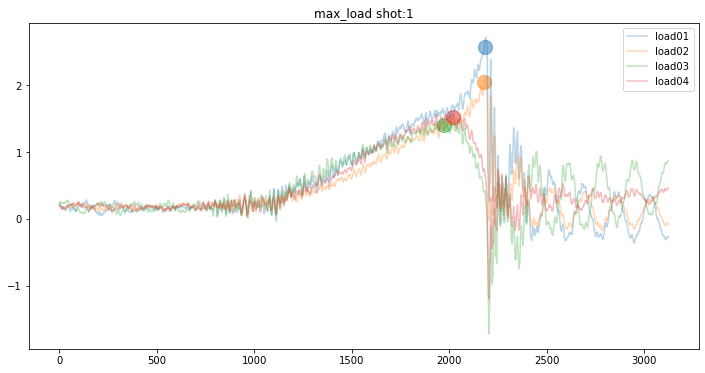

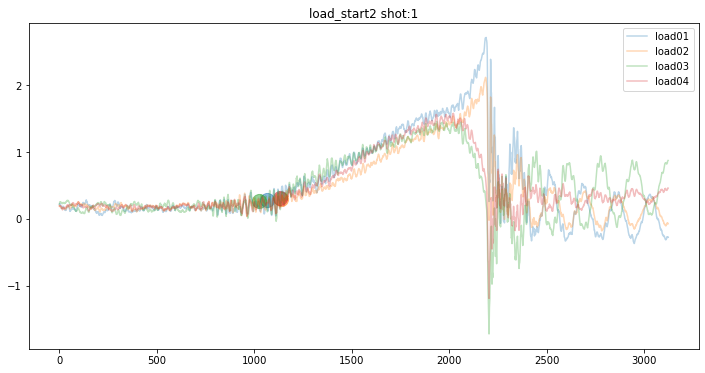

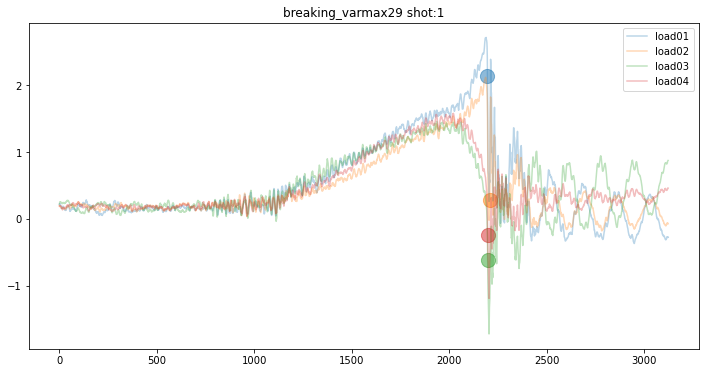

In [49]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start2, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_varmax29, sub_func=narrowing_var_ch,shot=shot_number, disp_chart=True)

In [50]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[2182, 2181, 1975, 2019], values：[2.578491744481206, 2.0465454927673763, 1.4077083597108553, 1.5246708376041869]
【荷重開始点】
 indicies：[1064, 1136, 1026, 1133], values：[0.2827243107769417, 0.297949874686717, 0.2627518796992487, 0.3072932330827072]
【破断点】　　
 indicies：[2197, 2208, 2198, 2198], values：[2.145, 0.28499999999999787, -0.6200000000000008, -0.23900000000000085]


# 全ショットにロジック適用

## データ読み込み
指定したインデックスの全ショットデータを読み込みます。これには時間がかかります。  
時間目安：10,000,000件読み込みで約3分

In [51]:
# 対象指定
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [52]:
%%time
dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)

2021-02-19 16:49:53,678 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-02-19 16:49:53,703 [INFO] データ件数: 9287537
2021-02-19 16:49:53,704 [INFO] Data read start. data_count: 9287537.


CPU times: user 1min 12s, sys: 4.67 s, total: 1min 16s
Wall time: 3min 5s


In [25]:
# ショットメタデータ読み込み
shots_meta_df = dr.read_shots_meta(shots_meta_index)

## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [26]:
# 最大荷重点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="max",
    func=max_load,
    sub_func=None,
)

2021-02-15 09:57:43,485 [INFO] apply start.
2021-02-15 09:57:43,744 [INFO] delete index 'shots-20201201010000-max-point' finished. result: {'acknowledged': True}
2021-02-15 09:58:00,501 [INFO] apply finished.


In [30]:
max_index = "shots-" + target + "-max-point"
max_df = dr.multi_process_read_all(max_index)
max_df.head(10)

2021-02-15 10:01:39,604 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-02-15 10:01:39,607 [INFO] データ件数: 11924
2021-02-15 10:01:39,609 [INFO] Data read start. data_count: 11924.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load03,1975,1975,3519.270899
1,1,load04,2019,2019,3811.677094
2,1,load02,2181,2181,5116.363732
3,1,load01,2182,2182,6446.229361
4,2,load02,5175,2050,3386.696885
5,2,load01,5178,2053,3914.540204
6,2,load04,5329,2204,4196.342244
7,2,load03,5330,2205,4051.479717
8,3,load01,8255,2017,4053.493263
9,3,load02,8274,2036,3592.297471


In [27]:
# 荷重開始点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="start",
    func=load_start2,
    sub_func=None,
)

2021-02-15 09:58:44,242 [INFO] apply start.
2021-02-15 09:58:44,340 [INFO] delete index 'shots-20201201010000-start-point' finished. result: {'acknowledged': True}
2021-02-15 09:59:10,455 [INFO] apply finished.


In [31]:
start_index = "shots-" + target + "-start-point"
start_df = dr.multi_process_read_all(start_index)
start_df.head(10)

2021-02-15 10:02:33,660 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-02-15 10:02:33,664 [INFO] データ件数: 11924
2021-02-15 10:02:33,664 [INFO] Data read start. data_count: 11924.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load03,1026,1026,656.879699
1,1,load01,1064,1064,706.810777
2,1,load04,1133,1133,768.233083
3,1,load02,1136,1136,744.874687
4,2,load03,4154,1029,703.703008
5,2,load01,4236,1111,840.307018
6,2,load04,4347,1222,1014.216792
7,2,load02,4392,1267,917.713033
8,3,load03,7359,1121,819.060150
9,3,load01,7389,1151,808.345865


In [28]:
# 破断点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="break",
    func=breaking_var_vrms,
    sub_func=ef.narrowing_var_ch,
)

2021-02-15 09:59:10,462 [INFO] apply start.
2021-02-15 09:59:10,539 [INFO] delete index 'shots-20201201010000-break-point' finished. result: {'acknowledged': True}
2021-02-15 10:01:27,532 [INFO] apply finished.


In [32]:
break_index = "shots-" + target + "-break-point"
break_df = dr.multi_process_read_all(break_index)
break_df.head(10)

2021-02-15 10:03:11,943 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-02-15 10:03:11,947 [INFO] データ件数: 11924
2021-02-15 10:03:11,948 [INFO] Data read start. data_count: 11924.


,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,1,load01,2118,2118,5193.576352,"[load03, load04]"
1,1,load02,2119,2119,4411.936831,"[load03, load04]"
2,1,load03,2120,2120,2501.957115,"[load03, load04]"
3,1,load04,2121,2121,3104.215573,"[load03, load04]"
4,2,load02,5335,2210,2219.562908,"[load01, load02]"
5,2,load01,5336,2211,2093.645799,"[load01, load02]"
6,2,load03,5336,2211,3792.094200,"[load01, load02]"
7,2,load04,5336,2211,3867.091950,"[load01, load02]"
8,3,load04,8366,2128,4516.358154,"[load01, load02]"
9,3,load03,8367,2129,4664.323945,"[load01, load02]"
